In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, PrecisionRecallDisplay

## Loading the Dataset
 The dataset is loaded and unnecessary columns, such as `id`, are removed and `age` is converted into years.

In [ ]:
df = pd.read_csv("cardio_data/dataset.csv",sep=";")
df.drop(["id"],axis=1,inplace=True)     #dropping the "id" column
df["age"] = df["age"]/365   #converting age into years
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
5,60.038356,1,151,67.0,120,80,2,2,0,0,0,0
6,60.583562,1,157,93.0,130,80,3,1,0,0,1,0
7,61.873973,2,178,95.0,130,90,3,3,0,0,1,1
8,48.405479,1,158,71.0,110,70,1,1,0,0,1,0
9,54.339726,1,164,68.0,110,60,1,1,0,0,0,0


### Checking the dataset for null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.4 MB


In [4]:
#checking for null values
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

### Splitting the features into numerical and categorical features

In [5]:
#number of unique values each feature has
df.nunique()

age            8076
gender            2
height          109
weight          287
ap_hi           153
ap_lo           157
cholesterol       3
gluc              3
smoke             2
alco              2
active            2
cardio            2
dtype: int64

In [6]:
categorical_columns = ["gender","cholesterol","gluc","smoke","alco","active","cardio"]
numerical_columns = ["age","height","weight","ap_hi","ap_lo"]

## Feature Selection
### Pre-processing numerical features

In [7]:
df[numerical_columns].describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339358,164.359229,74.205690,128.817286,96.630414
std,6.759594,8.210126,14.395757,154.011419,188.472530
min,29.583562,55.000000,10.000000,-150.000000,-70.000000
25%,48.394521,159.000000,65.000000,120.000000,80.000000
50%,53.980822,165.000000,72.000000,120.000000,80.000000
75%,58.430137,170.000000,82.000000,140.000000,90.000000
max,64.967123,250.000000,200.000000,16020.000000,11000.000000


#### Creating boxplot for `ap_lo` and `ap_hi` and filtering unrealistic values

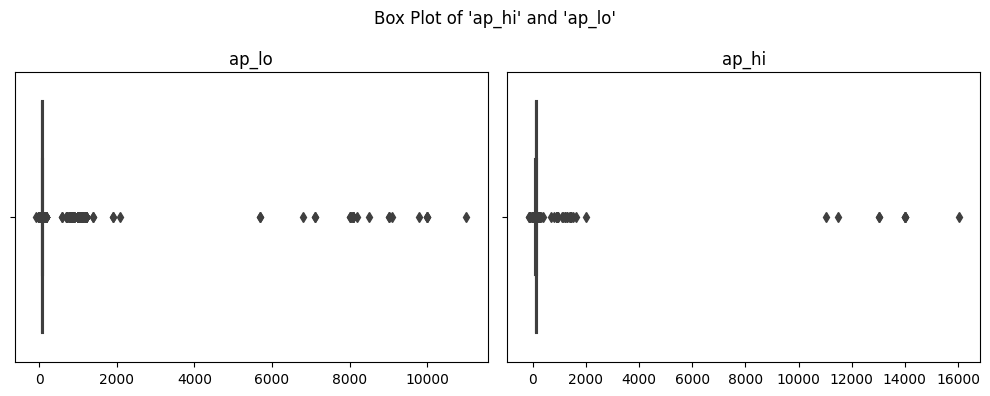

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

sns.boxplot(df, x= "ap_lo", ax = ax[0])
sns.boxplot(df, x= "ap_hi", ax = ax[1])
ax[0].set_title("ap_lo")
ax[0].set_xlabel(None)
ax[1].set_title("ap_hi")
ax[1].set_xlabel(None)
fig.suptitle("Box Plot of 'ap_hi' and 'ap_lo'")     #Boxplot of `ap_hi` and `ap_lo`
plt.tight_layout()

**Observation**: The blood pressure values should fall within a physiologically realistic range. Values outside this range will be filtered. We choose the thershold of 370/360 mm Hg as given [here](<https://pubmed.ncbi.nlm.nih.gov/7741618/#:~:text=The%20highest%20pressure%20recorded%20in,005).&text=BP%20was%20recorded%20in%2010,maximal%20lifting%20with%20slow%20exhalation.>).

In [9]:
#filetering unrealistic blood pressure values
df = df[(df["ap_hi"] <= 370) & (df["ap_hi"] >= 0)]
df = df[(df["ap_lo"] <= 360) & (df["ap_lo"] >= 0)].reset_index(drop=True) 

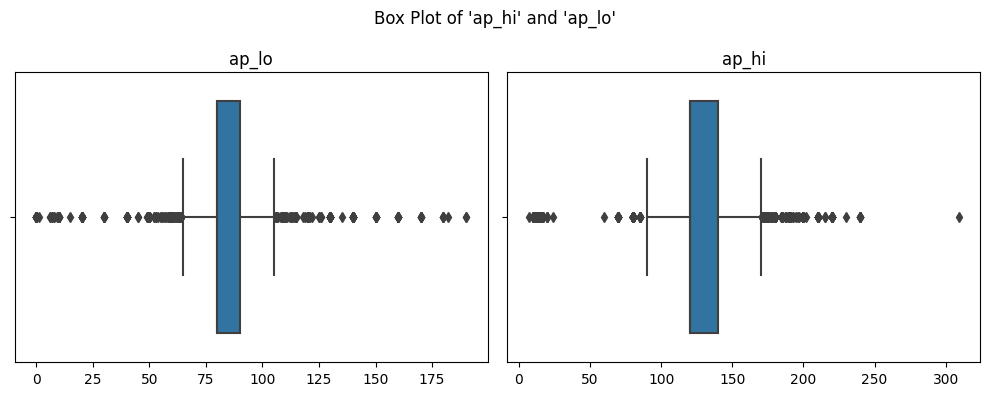

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

sns.boxplot(df, x= "ap_lo", ax = ax[0])
sns.boxplot(df, x= "ap_hi", ax = ax[1])
ax[0].set_title("ap_lo")
ax[0].set_xlabel(None)
ax[1].set_title("ap_hi")
ax[1].set_xlabel(None)
fig.suptitle("Box Plot of 'ap_hi' and 'ap_lo'")     #Boxplot of `ap_hi` and `ap_lo`
plt.tight_layout()

#### Creating histogram plot with `cardio` as hue

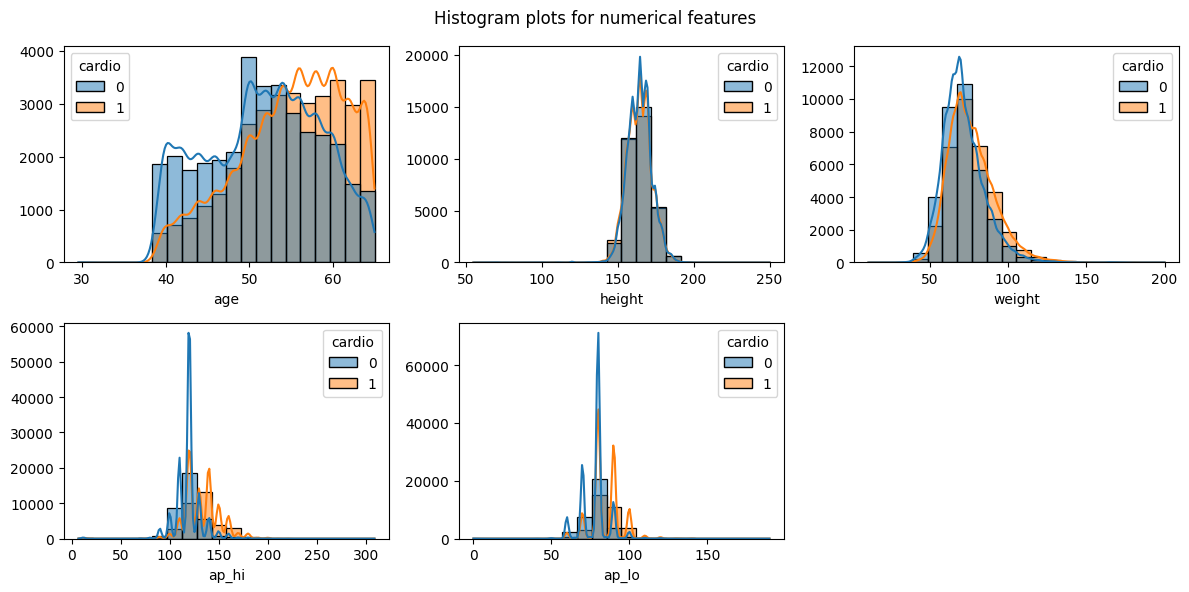

In [11]:
fig, ax = plt.subplots(nrows= int(np.ceil(len(numerical_columns)/3)), ncols=3, figsize = (12,6))
for k,col in enumerate(numerical_columns):
    r = int(k//3)
    c = int(k%3)
    sns.histplot(data = df, x = col, bins= 20, hue = "cardio", ax=ax[r,c],kde= True)
    ax[r,c].set_ylabel(None)
k += 1
r = int(k//3)
c = int(k%3)
fig.delaxes(ax=ax[r,c])
plt.suptitle("Histogram plots for numerical features")      #Histogram plot for numerical features
plt.tight_layout()

#### Creating boxplot with `cardio` as hue

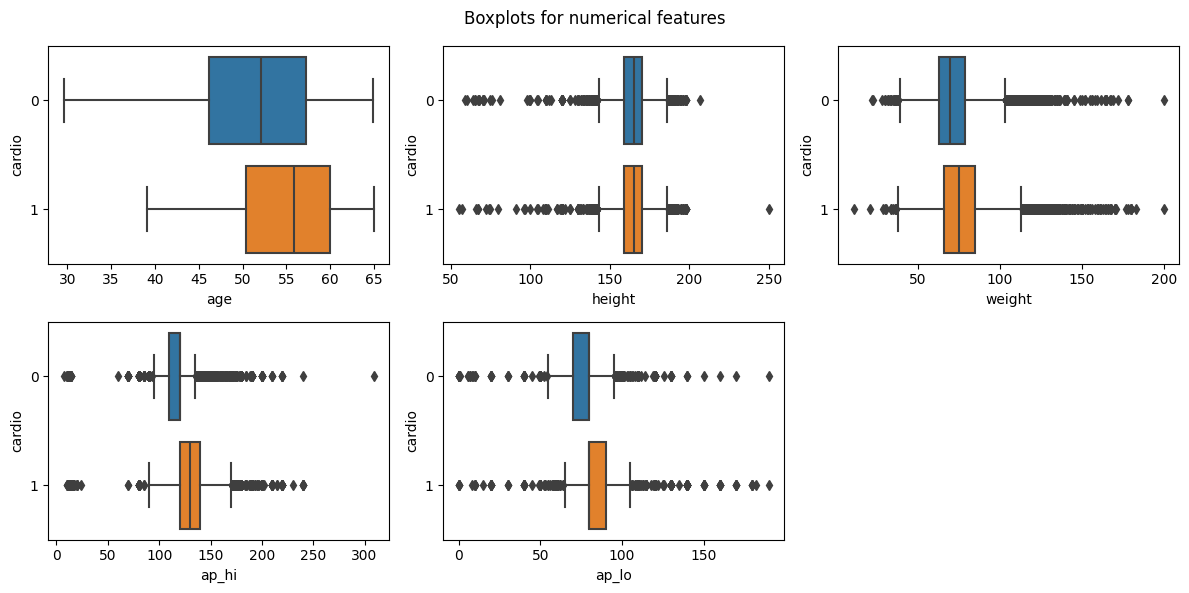

In [12]:
df["cardio"] = df["cardio"].astype(str)
fig, ax = plt.subplots(nrows= int(np.ceil(len(numerical_columns)/3)), ncols=3, figsize = (12,6))
for k,col in enumerate(numerical_columns):
    r = int(k//3)
    c = int(k%3)
    sns.boxplot(data = df, x = col, y = "cardio", ax=ax[r,c])
k += 1
r = int(k//3)
c = int(k%3)
fig.delaxes(ax=ax[r,c])
plt.suptitle("Boxplots for numerical features")     #Boxplot for numerical features
plt.tight_layout()

#### Scaling numerical features

The numerical features is scaled using standard scaler as the data is normally distributed which is evident from the histogram plot.

In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit(df[numerical_columns])
scaled_numerical_data = scaler.transform(df[numerical_columns])
df[numerical_columns] = scaled_numerical_data
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0,0


#### Checking correlation between numerical features using correlation matrix

In [14]:
corr_matrix = df[numerical_columns].corr()
corr_matrix

,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.080724,0.055154,0.197734,0.150938
height,-0.080724,1.000000,0.291529,0.017576,0.035898
weight,0.055154,0.291529,1.000000,0.254697,0.245399
ap_hi,0.197734,0.017576,0.254697,1.000000,0.644223
ap_lo,0.150938,0.035898,0.245399,0.644223,1.000000


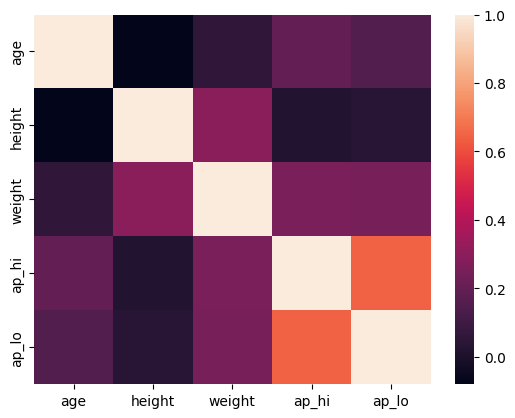

In [15]:
sns.heatmap(data= corr_matrix)
plt.show()

Thus, no two numerical features are correlated.

### Pre-processing categorical features ###

#### Looking at categorical features

In [16]:
df[categorical_columns].head(10)

,gender,cholesterol,gluc,smoke,alco,active,cardio
0,2,1,1,0,0,1,0
1,1,3,1,0,0,1,1
2,1,3,1,0,0,0,1
3,2,1,1,0,0,1,1
4,1,1,1,0,0,0,0
5,1,2,2,0,0,0,0
6,1,3,1,0,0,1,0
7,2,3,3,0,0,1,1
8,1,1,1,0,0,1,0
9,1,1,1,0,0,0,0


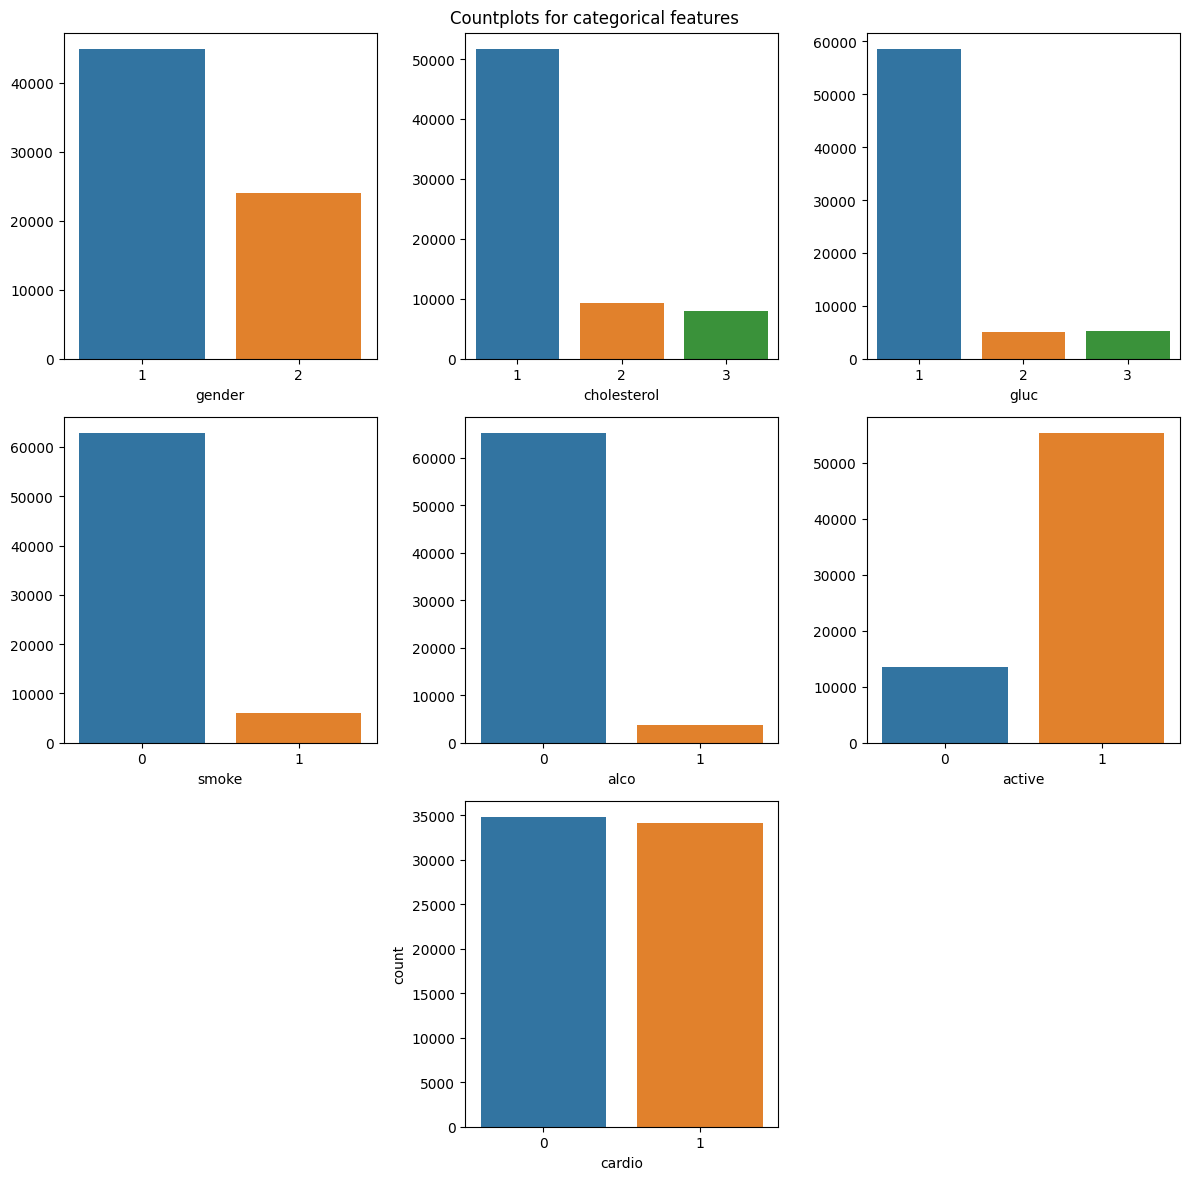

In [17]:
fig, ax = plt.subplots(nrows= int(np.ceil(len(categorical_columns)/3)), ncols=3, figsize = (12,12))
for k,col in enumerate(categorical_columns[:-1]):
    r = int(k//3)
    c = int(k%3)
    sns.countplot(data = df, x = col, ax=ax[r,c])
    ax[r,c].set_ylabel(None)
sns.countplot(data=df, x = "cardio", ax=ax[2,1])
fig.delaxes(ax=ax[2,0])
fig.delaxes(ax=ax[2,2])
plt.suptitle("Countplots for categorical features")     #countplot for each categorical features
plt.tight_layout()

#### Creating countplot with `cardio` as hue

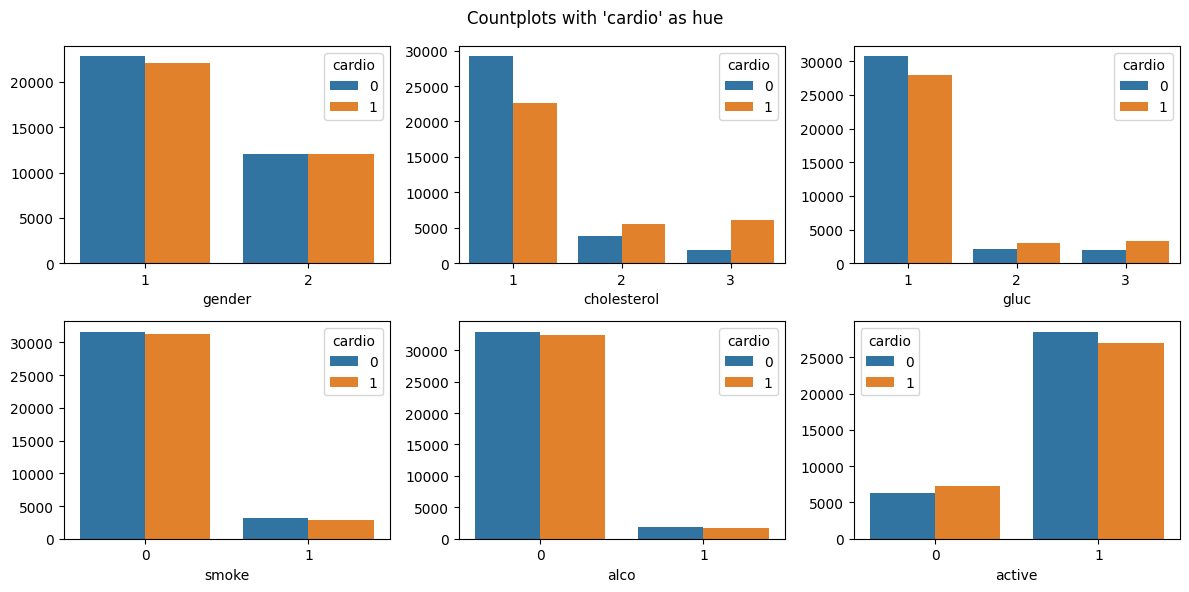

In [18]:
df["cardio"] = df["cardio"].astype(str)
fig, ax = plt.subplots(nrows= int(np.ceil(len(categorical_columns[:-1])/3)), ncols=3, figsize = (12,6))
for k,col in enumerate(categorical_columns[:-1]):
    r = int(k//3)
    c = int(k%3)
    sns.countplot(data = df, x = col, hue = "cardio", ax=ax[r,c])
    ax[r,c].set_ylabel(None)
plt.suptitle("Countplots with 'cardio' as hue")     #countplot with `cardio` as hue
plt.tight_layout()

#### Checking relation between categorical features

In [19]:
#this function calculates chi^2 and p-value from the contigency table between two features
def calc_chi2(df, feature1, feature2):
    contingency_table = pd.crosstab(df[feature1],df[feature2],margins= True)
    chi2_value, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2_value, p_value

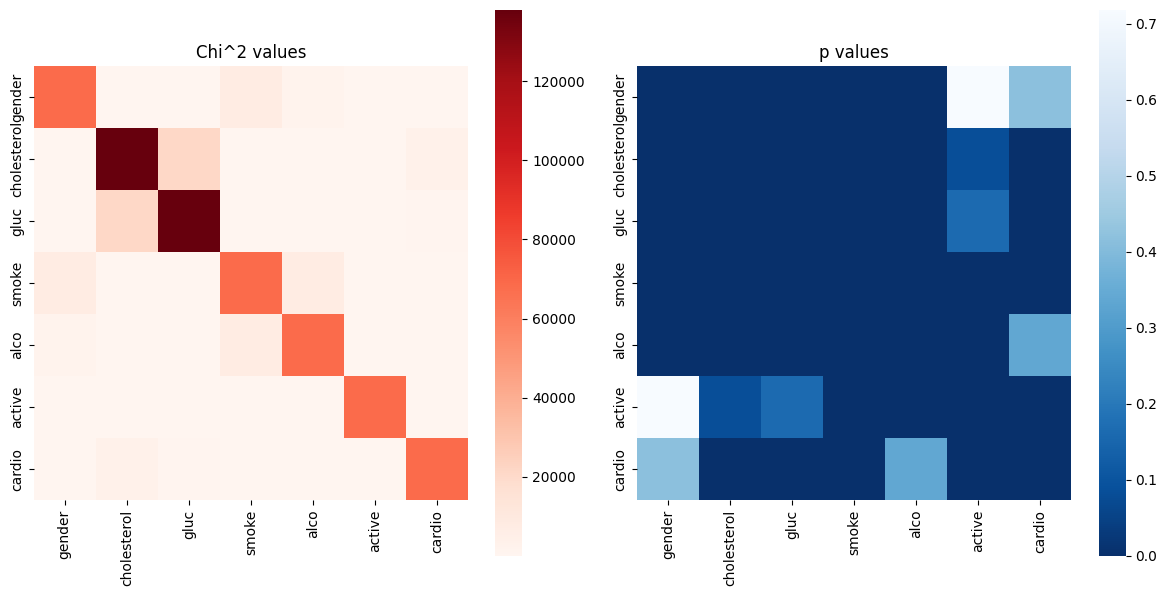

In [20]:
chi2_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))    #matrix for storing chi^2 values between all the features
p_matrix = np.zeros_like(chi2_matrix)   #matrix for storing p-values between all the features

#using calc_chi2 to calculate chi^2-values and p-values between each categorical variables
for i,col1 in enumerate(categorical_columns):
    for j,col2 in enumerate(categorical_columns):
        chi2_value, p_value = calc_chi2(df,col1,col2)
        chi2_matrix[i,j] = chi2_value
        p_matrix[i,j] = p_value

chi2_matrix = pd.DataFrame(data=chi2_matrix, index=categorical_columns, columns=categorical_columns) 
p_matrix = pd.DataFrame(data=p_matrix, index=categorical_columns, columns=categorical_columns)

#heatmap for chi^2-values and p-values
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.heatmap(chi2_matrix, ax = ax[0], cmap="Reds")
sns.heatmap(p_matrix, ax=ax[1], cmap="Blues_r")
ax[0].set_aspect("equal")
ax[0].set_title("Chi^2 values")
ax[1].set_aspect("equal")
ax[1].set_title("p values")
plt.tight_layout()

In [21]:
p_matrix

,gender,cholesterol,gluc,smoke,alco,active,cardio
gender,0.000000e+00,3.618490e-18,2.645815e-05,0.000000e+00,0.000000e+00,7.181048e-01,4.167186e-01
cholesterol,3.618490e-18,0.000000e+00,0.000000e+00,2.583436e-07,9.822637e-28,8.291622e-02,0.000000e+00
gluc,2.645815e-05,0.000000e+00,0.000000e+00,1.262401e-04,5.049004e-12,1.607945e-01,6.117519e-123
smoke,0.000000e+00,2.583436e-07,1.262401e-04,0.000000e+00,0.000000e+00,2.961248e-09,1.040722e-03
alco,0.000000e+00,9.822637e-28,5.049004e-12,0.000000e+00,0.000000e+00,5.690918e-09,3.377477e-01
active,7.181048e-01,8.291622e-02,1.607945e-01,2.961248e-09,5.690918e-09,0.000000e+00,7.485367e-20
cardio,4.167186e-01,0.000000e+00,6.117519e-123,1.040722e-03,3.377477e-01,7.485367e-20,0.000000e+00


The p_value of the feature `alco` as compared with `cardio` is greater than 0.05, which implies that `alco` is independent of the target variable `cardio`. Also, The p_value of the feature `alco` as compared with other categorical features is less than 0.05, which implies that `alco` is dependent on all other categorical features. Thus, we can safely discard `alco` from out ddataset.

In [22]:
df.drop(["alco"], axis = 1, inplace = True)     #dropping the "alco" feature

## Splitting the dataset into trainning and test

In [23]:
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0


In [24]:
X = df.drop(["cardio"],axis=1)
y = df["cardio"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

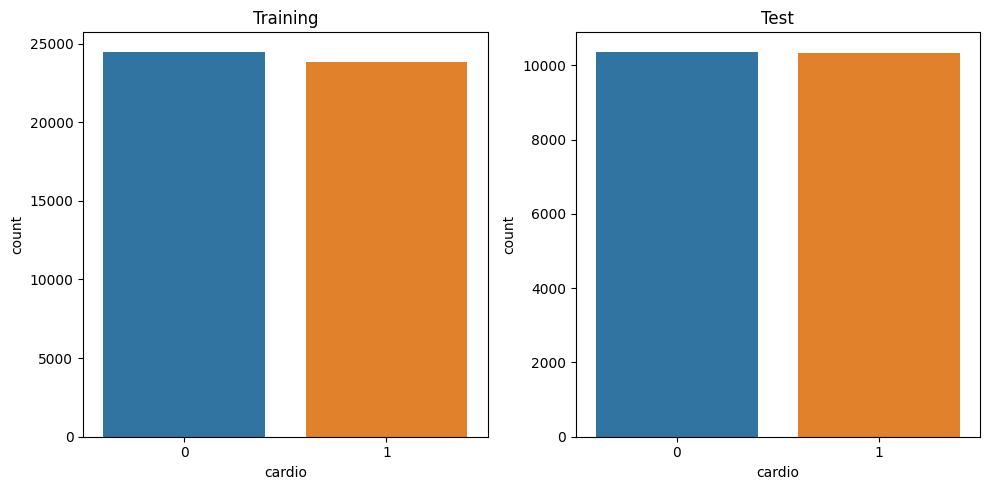

In [25]:
#looking at the counts for training and test dataset
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.countplot(data=df, x = y_train, ax = ax[0])
ax[0].set_title("Training")
sns.countplot(data=df, x = y_test, ax = ax[1])
ax[1].set_title("Test")
plt.tight_layout()

The training and test have similar distribution of target variable `cardio`.

## Model Selection

### Logistic Regression
#### Defining parameter grid and performing cross validation

In [26]:
param_grid = {"C" : [0.001, 0.01, 0.1,1,10], "solver": ["lbfgs","newton-cholesky", "saga"]}
classifier = GridSearchCV(estimator= LogisticRegression(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
10,"{'C': 1, 'solver': 'newton-cholesky'}",0.659246,0.008029,1
12,"{'C': 10, 'solver': 'lbfgs'}",0.659246,0.008029,1
13,"{'C': 10, 'solver': 'newton-cholesky'}",0.659246,0.008029,1
14,"{'C': 10, 'solver': 'saga'}",0.659246,0.008029,1
9,"{'C': 1, 'solver': 'lbfgs'}",0.659218,0.007989,5
11,"{'C': 1, 'solver': 'saga'}",0.659218,0.007989,5
6,"{'C': 0.1, 'solver': 'lbfgs'}",0.659079,0.008069,7
7,"{'C': 0.1, 'solver': 'newton-cholesky'}",0.659051,0.008060,8
8,"{'C': 0.1, 'solver': 'saga'}",0.659051,0.008060,8
3,"{'C': 0.01, 'solver': 'lbfgs'}",0.658802,0.008318,10


Parameter grids are created for various classification models and the best three model with the best parameters are selected for further prediction. Here, recall score is selected because we want to increase the chance of predicting True Positive compared to False Negative.

$$
\begin{align*}
    \text{Recall} = \frac{\text{True Postive}}{\text{True Postive} + \text{False Negative}}
\end{align*}
$$

In [27]:
best_params = classifier.best_params_
print(best_params)

{'C': 1, 'solver': 'newton-cholesky'}


#### Training the classifier and predicting

In [28]:
LR = LogisticRegression(C = best_params["C"], solver= best_params["solver"]).fit(X_train, y_train)
y_pred = LR.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [29]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8110,2258
Actual 1,3332,7000


In [30]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.00%
Precision: 75.61%
Recall: 67.75%
F1_score: 71.47%


#### Plotting ROC curve and Precision-Recall curve

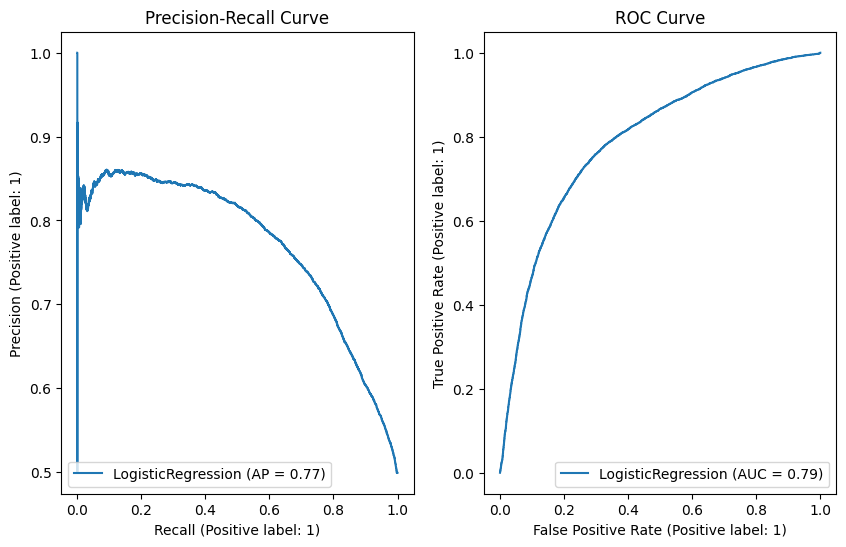

In [31]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(LR, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(LR, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### K-Nearest Neighbors
#### Defining parameter grid and performing cross validation

In [32]:
param_grid = {"n_neighbors" : [10,50,100,200,500]}
classifier = GridSearchCV(estimator= KNeighborsClassifier(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
1,{'n_neighbors': 50},0.659030,0.005070,1
2,{'n_neighbors': 100},0.651077,0.005619,2
3,{'n_neighbors': 200},0.641919,0.004293,3
0,{'n_neighbors': 10},0.633654,0.005795,4
4,{'n_neighbors': 500},0.624531,0.005040,5


In [33]:
best_params = classifier.best_params_
print(best_params)

{'n_neighbors': 50}


#### Training the classifier and predicting

In [34]:
KNN = KNeighborsClassifier(n_neighbors= best_params["n_neighbors"]).fit(X_train, y_train)
y_pred = KNN.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [35]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8121,2247
Actual 1,3341,6991


In [36]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.00%
Precision: 75.68%
Recall: 67.66%
F1_score: 71.45%


#### Plotting ROC curve and Precision-Recall curve

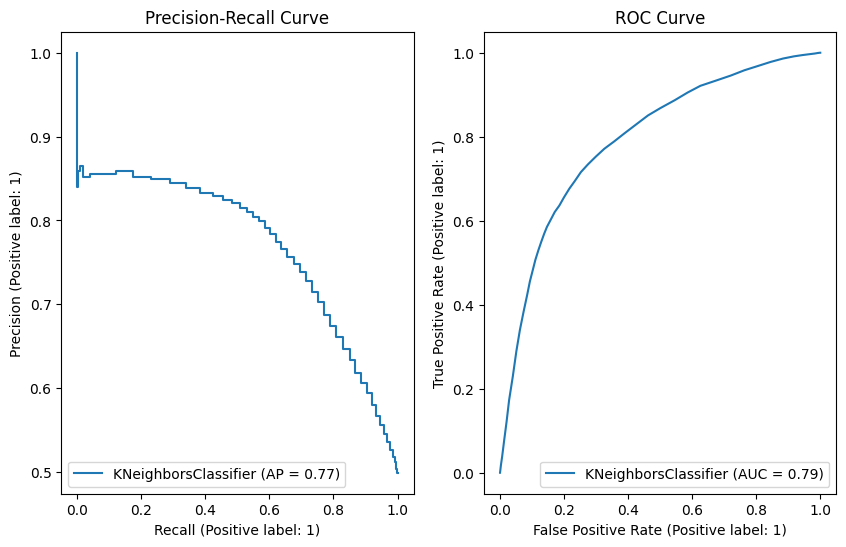

In [37]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(KNN, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(KNN, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Linear Support Vector Classifier
#### Defining parameter grid and performing cross validation

In [38]:
param_grid = {"C" : [1e-6,1e-5,1e-4,1e-3], "loss": ["hinge", "squared_hinge"]}
classifier = GridSearchCV(estimator= LinearSVC(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
0,"{'C': 1e-06, 'loss': 'hinge'}",0.765228,0.010123,1
2,"{'C': 1e-05, 'loss': 'hinge'}",0.760412,0.009611,2
1,"{'C': 1e-06, 'loss': 'squared_hinge'}",0.735693,0.008275,3
3,"{'C': 1e-05, 'loss': 'squared_hinge'}",0.690363,0.005295,4
5,"{'C': 0.0001, 'loss': 'squared_hinge'}",0.669331,0.004404,5
7,"{'C': 0.001, 'loss': 'squared_hinge'}",0.661327,0.003452,6
4,"{'C': 0.0001, 'loss': 'hinge'}",0.657688,0.005132,7
6,"{'C': 0.001, 'loss': 'hinge'}",0.635922,0.005140,8


In [39]:
best_params = classifier.best_params_
print(best_params)

{'C': 1e-06, 'loss': 'hinge'}


#### Training the classifier and predicting

In [40]:
Linear_SVM = LinearSVC(C = best_params["C"], loss= best_params["loss"]).fit(X_train, y_train)
y_pred = Linear_SVM.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [41]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,6849,3519
Actual 1,2396,7936


In [42]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 71.43%
Precision: 69.28%
Recall: 76.81%
F1_score: 72.85%


#### Plotting ROC curve and Precision-Recall curve

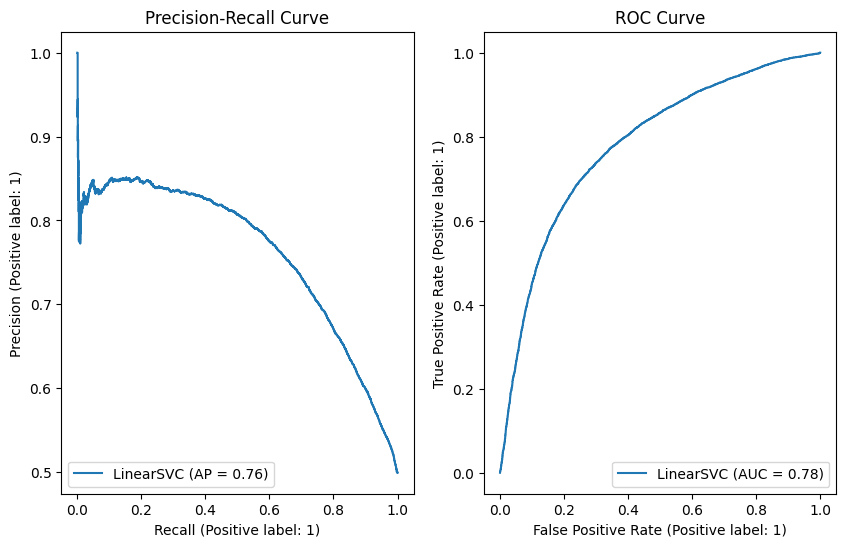

In [43]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(Linear_SVM, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(Linear_SVM, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Support Vector Classifier
#### Defining parameter grid and performing cross validation

In [44]:
param_grid = {"C": [0.01, 0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, 1]}
classifier = GridSearchCV(estimator= SVC(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
3,"{'C': 0.01, 'gamma': 1}",0.807919,0.002032,1
7,"{'C': 0.1, 'gamma': 1}",0.724324,0.003823,2
11,"{'C': 1, 'gamma': 1}",0.685117,0.007002,3
6,"{'C': 0.1, 'gamma': 0.1}",0.668222,0.003974,4
13,"{'C': 10, 'gamma': 0.01}",0.666035,0.004511,5
2,"{'C': 0.01, 'gamma': 0.1}",0.665975,0.004188,6
14,"{'C': 10, 'gamma': 0.1}",0.665406,0.003473,7
10,"{'C': 1, 'gamma': 0.1}",0.665321,0.003902,8
9,"{'C': 1, 'gamma': 0.01}",0.656801,0.004973,9
15,"{'C': 10, 'gamma': 1}",0.636386,0.003797,10


In [45]:
best_params = classifier.best_params_
print(best_params)

{'C': 0.01, 'gamma': 1}


#### Training the classifier and predicting

In [46]:
SVM = SVC(C = best_params["C"], gamma = best_params["gamma"]).fit(X_train, y_train)
y_pred = SVM.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [47]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,6002,4366
Actual 1,2079,8253


In [48]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 68.86%
Precision: 65.40%
Recall: 79.88%
F1_score: 71.92%


#### Plotting ROC curve and Precision-Recall curve

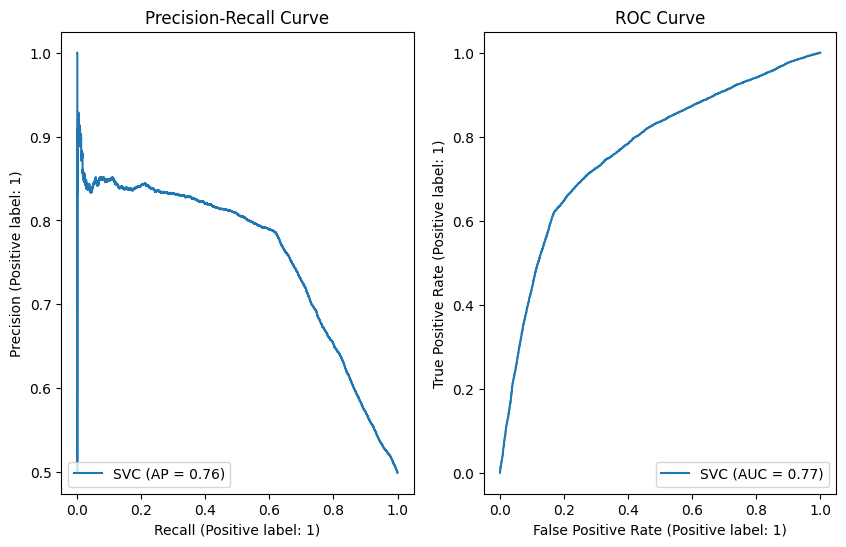

In [49]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(SVM, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(SVM, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Decision Tree
#### Defining parameter grid and performing cross validation

In [50]:
param_grid = {"criterion": ["gini", "entropy"],"max_depth": [5,10,20]}
classifier = GridSearchCV(estimator= DecisionTreeClassifier() , param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
4,"{'criterion': 'entropy', 'max_depth': 10}",0.665925,0.012159,1
1,"{'criterion': 'gini', 'max_depth': 10}",0.660233,0.009755,2
3,"{'criterion': 'entropy', 'max_depth': 5}",0.642059,0.017954,3
0,"{'criterion': 'gini', 'max_depth': 5}",0.640168,0.015953,4
2,"{'criterion': 'gini', 'max_depth': 20}",0.633345,0.006372,5
5,"{'criterion': 'entropy', 'max_depth': 20}",0.628667,0.007118,6


In [51]:
best_params = classifier.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 10}


#### Training the classifier and predicting 

In [52]:
Decision_Tree = DecisionTreeClassifier(criterion = best_params["criterion"], max_depth=best_params["max_depth"]).fit(X_train, y_train)
y_pred = Decision_Tree.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [53]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7984,2384
Actual 1,3222,7110


In [54]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 72.92%
Precision: 74.89%
Recall: 68.82%
F1_score: 71.72%


#### Plotting ROC curve and Precision-Recall curve

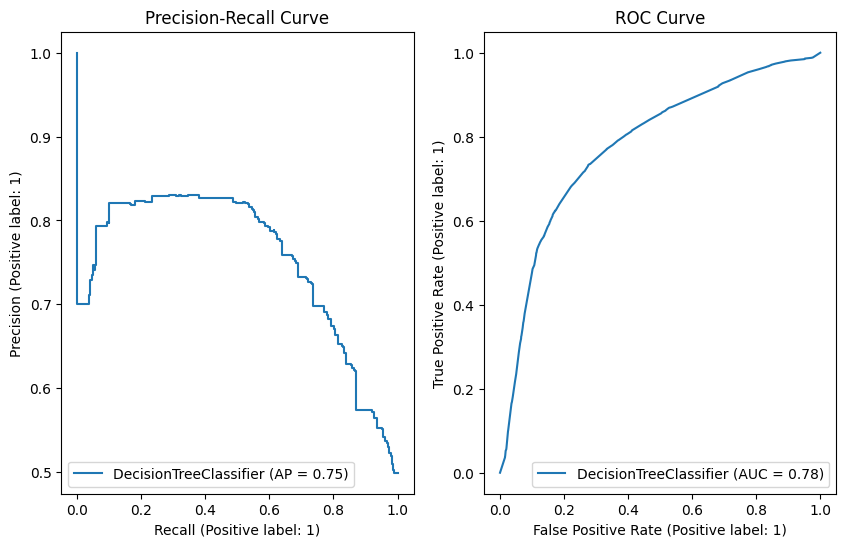

In [55]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(Decision_Tree, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(Decision_Tree, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Bagging
#### Defining parameter grid and performing cross validation

In [56]:
param_grid = {"n_estimators" : [50, 100,500,1000], "max_samples": [0.5, 0.7, 0.9]}
classifier = GridSearchCV(estimator= BaggingClassifier(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
6,"{'max_samples': 0.7, 'n_estimators': 500}",0.688339,0.002628,1
10,"{'max_samples': 0.9, 'n_estimators': 500}",0.687282,0.002439,2
11,"{'max_samples': 0.9, 'n_estimators': 1000}",0.686967,0.003839,3
7,"{'max_samples': 0.7, 'n_estimators': 1000}",0.686884,0.003241,4
3,"{'max_samples': 0.5, 'n_estimators': 1000}",0.685909,0.002632,5
2,"{'max_samples': 0.5, 'n_estimators': 500}",0.685606,0.002955,6
5,"{'max_samples': 0.7, 'n_estimators': 100}",0.683816,0.003923,7
9,"{'max_samples': 0.9, 'n_estimators': 100}",0.683404,0.002521,8
1,"{'max_samples': 0.5, 'n_estimators': 100}",0.682208,0.001041,9
0,"{'max_samples': 0.5, 'n_estimators': 50}",0.679624,0.003573,10


In [57]:
best_params = classifier.best_params_
print(best_params)

{'max_samples': 0.7, 'n_estimators': 500}


#### Training the classifier and predicting

In [58]:
BC = BaggingClassifier(n_estimators=best_params["n_estimators"], max_samples= best_params["max_samples"])
BC = BC.fit(X_train,y_train)
y_pred = BC.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [59]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7663,2705
Actual 1,3064,7268


In [60]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 72.13%
Precision: 72.88%
Recall: 70.34%
F1_score: 71.59%


#### Plotting ROC curve and Precision-Recall curve

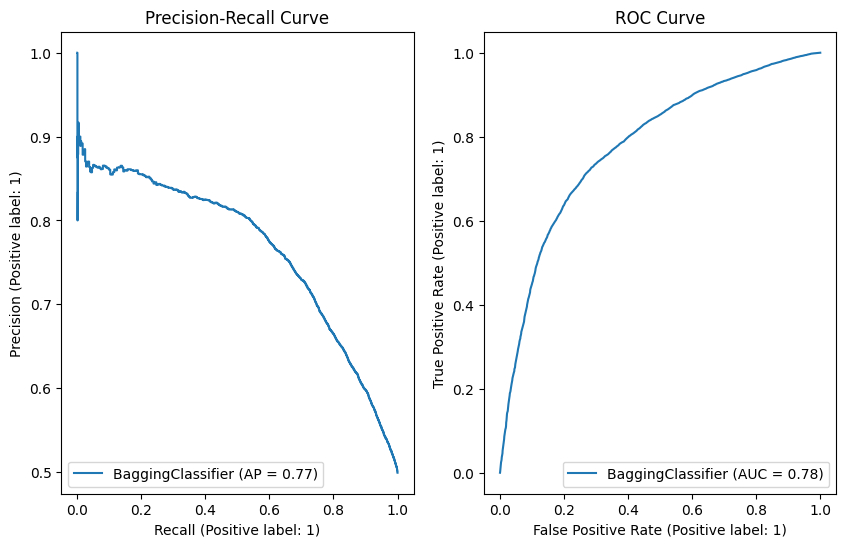

In [61]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(BC, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(BC, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Random Forest
#### Defining parameter grid and performing cross validation

In [63]:
param_grid = {"n_estimators": [100,500,1000], "criterion" : ["gini", "entropy"]}
classifier = GridSearchCV(estimator= RandomForestClassifier(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
1,"{'criterion': 'gini', 'n_estimators': 500}",0.691454,0.002852,1
4,"{'criterion': 'entropy', 'n_estimators': 500}",0.691342,0.002714,2
2,"{'criterion': 'gini', 'n_estimators': 1000}",0.691144,0.003321,3
5,"{'criterion': 'entropy', 'n_estimators': 1000}",0.690525,0.004057,4
3,"{'criterion': 'entropy', 'n_estimators': 100}",0.688091,0.003838,5
0,"{'criterion': 'gini', 'n_estimators': 100}",0.686692,0.004758,6


In [64]:
best_params = classifier.best_params_
print(best_params)

{'criterion': 'gini', 'n_estimators': 500}


#### Training the classifier and predicting 

In [65]:
Random_Forest = RandomForestClassifier(n_estimators = best_params["n_estimators"], criterion= best_params["criterion"])
Random_Forest = Random_Forest.fit(X_train,y_train)
y_pred = Random_Forest.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [66]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7548,2820
Actual 1,2988,7344


In [67]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 71.94%
Precision: 72.26%
Recall: 71.08%
F1_score: 71.66%


#### Plotting ROC curve and Precision-Recall curve

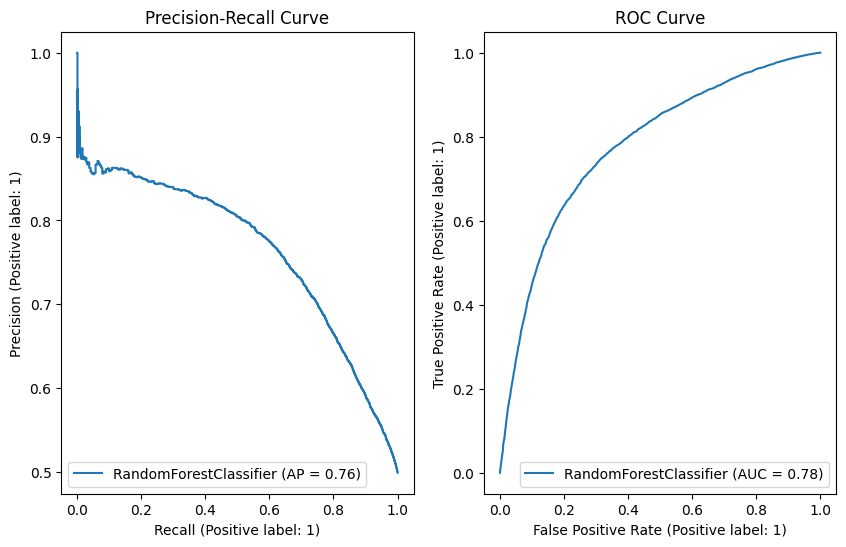

In [68]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(Random_Forest, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(Random_Forest, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Gradient Boosting
#### Defining parameter grid and performing Cross Validation

In [69]:
param_grid = {"learning_rate" : [0.1, 0.5, 1, 10],"n_estimators": [3,5,10,50]}
classifier = GridSearchCV(estimator= GradientBoostingClassifier(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
8,"{'learning_rate': 1, 'n_estimators': 3}",0.703095,0.004311,1
10,"{'learning_rate': 1, 'n_estimators': 10}",0.693915,0.002868,2
6,"{'learning_rate': 0.5, 'n_estimators': 10}",0.689511,0.003049,3
9,"{'learning_rate': 1, 'n_estimators': 5}",0.689015,0.012131,4
5,"{'learning_rate': 0.5, 'n_estimators': 5}",0.683808,0.012703,5
7,"{'learning_rate': 0.5, 'n_estimators': 50}",0.682948,0.002799,6
3,"{'learning_rate': 0.1, 'n_estimators': 50}",0.681393,0.003775,7
11,"{'learning_rate': 1, 'n_estimators': 50}",0.677571,0.004933,8
0,"{'learning_rate': 0.1, 'n_estimators': 3}",0.662847,0.002830,9
1,"{'learning_rate': 0.1, 'n_estimators': 5}",0.662847,0.002830,9


In [70]:
best_params = classifier.best_params_
print(best_params)

{'learning_rate': 1, 'n_estimators': 3}


#### Training and predicting the classifier

In [71]:
Gradient_Boost = GradientBoostingClassifier(learning_rate= best_params["learning_rate"], n_estimators= best_params["n_estimators"])
Gradient_Boost  = Gradient_Boost.fit(X_train, y_train)
y_pred = Gradient_Boost.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [72]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7664,2704
Actual 1,2899,7433


In [73]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 72.93%
Precision: 73.33%
Recall: 71.94%
F1_score: 72.63%


#### Plotting ROC curve and Precision-Recall curve

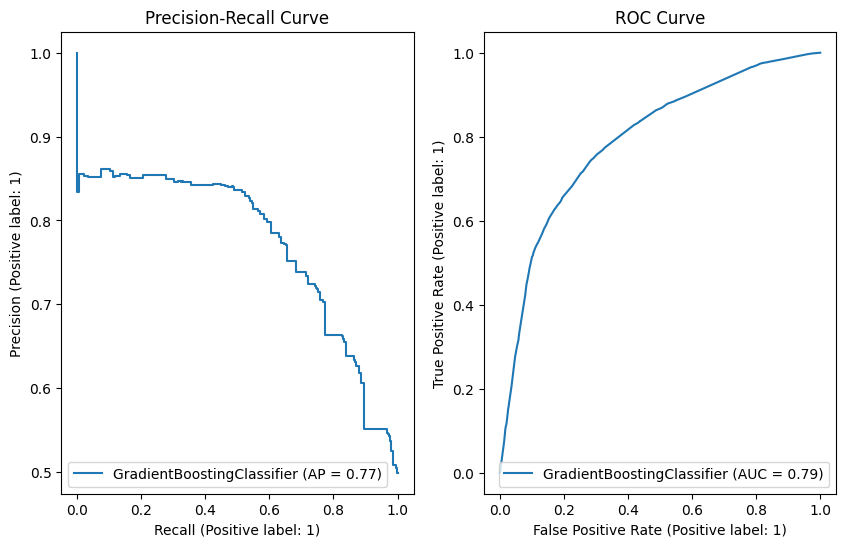

In [74]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(Gradient_Boost, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(Gradient_Boost, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Adaptive Boosting
#### Defining parameter grid and performing cross validation

In [75]:
param_grid = {"n_estimators": [10,50,100]}
classifier = GridSearchCV(estimator= AdaBoostClassifier(), param_grid= param_grid,cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
classifier.fit(X_train, y_train)
parameters = pd.DataFrame(classifier.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters

,params,mean_test_score,std_test_score,rank_test_score
1,{'n_estimators': 50},0.646620,0.006940,1
2,{'n_estimators': 100},0.645296,0.006570,2
0,{'n_estimators': 10},0.635571,0.005152,3


In [76]:
best_params = classifier.best_params_
print(best_params)

{'n_estimators': 50}


#### Training the classifier and predicting 

In [77]:
AdaBoost = AdaBoostClassifier(n_estimators= best_params["n_estimators"]).fit(X_train, y_train)
y_pred = AdaBoost.predict(X_test)

#### Computing the confusion matrix and accuracy scores

In [78]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8307,2061
Actual 1,3538,6794


In [79]:
accuracy = accuracy_score(y_test, y_pred) *100
precision = precision_score(y_test, y_pred) *100
recall = recall_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 72.95%
Precision: 76.73%
Recall: 65.76%
F1_score: 70.82%


#### Plotting ROC curve and Precision-Recall curve

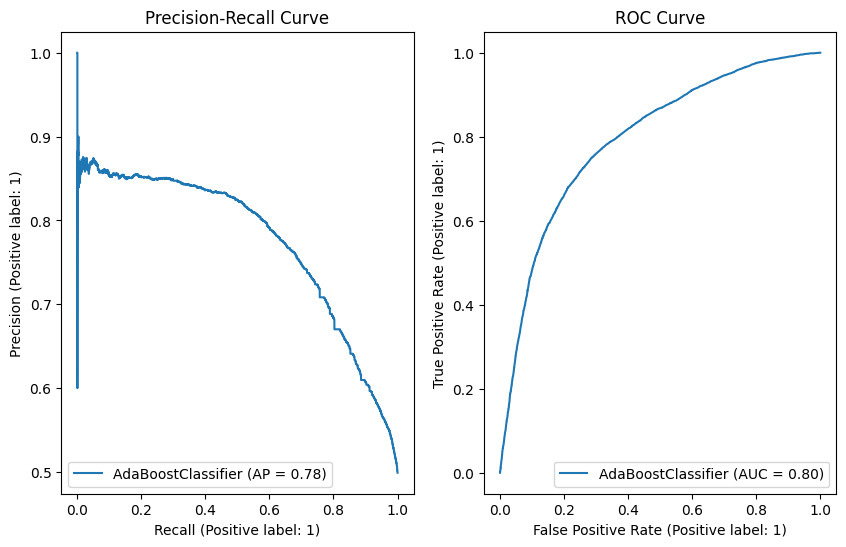

In [80]:
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(AdaBoost, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(AdaBoost, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

## Conclusion

The best model for predicting cardiovascular disease is the Support Vector Machine (SVM), achieving a recall score of approximately 80% and an F1 score of around 72%. The second-best model is the Support Vector Classifier (SVC) with a linear kernel, which has a slightly lower recall score of 77% but a comparable F1 score of 73%. Additionally, the linear SVC is more interpretable compared to the SVM with non-linear kernels, making it a preferable choice when model explainability is important.